# Customer Segmentation & Campaign Targeting (Bank Marketing Dataset)

## Objective

The goal of this project is to:
- Segment customers based on demographic and behavioral traits
- Simulate campaign targeting
- Design and evaluate A/B tests to improve customer retention and conversion


#### Note: 
Due to confidentiality agreements, I cannot share actual data or full workflows from my professional projects.This example represents a simplified version of one component from a real segmentation and targeting project I worked on. It demonstrates the typical workflow and methodology used in production — including customer segmentation, targeting logic,  and test/control evaluation.The dataset and code here are used  to show the types of problems I solve and the approach I take, not the actual results or data from company systems.  

In [1]:
#impots 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
# getting the data
df = pd.read_csv("bank.csv") 


print("Shape:", df.shape)
df.head()


Shape: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### EDA

In [3]:
# Check balance of target variable
df['deposit'].value_counts(normalize=True)


no     0.52616
yes    0.47384
Name: deposit, dtype: float64

In [4]:
# Check nulls
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [5]:
# Check unique values
df.nunique()

age            76
job            12
marital         3
education       4
default         2
balance      3805
housing         2
loan            2
contact         3
day            31
month          12
duration     1428
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64

In [6]:
data = df.copy()

###  Data Preparation

In [7]:
print(data.columns.tolist())


['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


In [8]:
# Standardize column names
data.columns = data.columns.str.strip().str.lower()



In [9]:
# Replace 'unknown' categorical columns
for col in ['job', 'marital', 'education', 'contact', 'poutcome']:
    data[col] = data[col].replace('unknown', pd.NA)



In [10]:
# Drop rows with any NA 
data.dropna(inplace=True)



In [11]:

binary_map = {'yes': 1, 'no': 0}
for col in ['default', 'housing', 'loan', 'deposit']:
    data[col] = data[col].map(binary_map)

# One-hot encode other categorical columns
categorical = ['job', 'marital', 'education', 'contact', 'poutcome']
data = pd.get_dummies(data, columns=categorical, drop_first=True)

In [12]:
# Features to use for clustering
features = ['age', 'balance', 'duration', 'campaign', 'previous'] + [col for col in data.columns if col.startswith(tuple(categorical))]
X = data[features]

In [13]:

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Clustering

In [14]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
# A method that works well for customer behavior clustering when features are numeric and scaled.
kmeans = KMeans(n_clusters=4, random_state=42)
data['segment'] = kmeans.fit_predict(X_scaled)


/Users/lilit/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
data['segment'].value_counts().sort_index()


0    840
1    960
2    646
3    229
Name: segment, dtype: int64

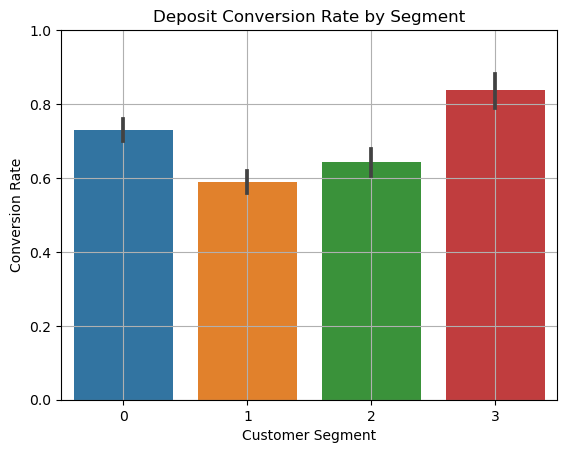

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion rate by segment
sns.barplot(x='segment', y='deposit', data=data)
plt.title('Deposit Conversion Rate by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Conversion Rate')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [17]:
# Profile the segments by key averages
segment_profile = data.groupby('segment')[['age', 'balance', 'duration', 'campaign', 'previous', 'deposit']].mean()
print(segment_profile)


               age      balance    duration  campaign  previous   deposit
segment                                                                  
0        39.707143  2163.384524  341.184524  1.929762  3.180952  0.728571
1        43.208333  1390.302083  353.097917  1.896875  3.390625  0.589583
2        32.009288  1441.247678  329.540248  1.948916  3.363777  0.643963
3        67.842795  3106.104803  410.218341  1.646288  3.152838  0.838428


From the segmentation results, **Segment 3** emerged as the most responsive group, with an average deposit conversion rate of **83.8%** — significantly above the overall average.

This segment is characterized by:
- Older customers (avg. age ≈ 68)
- High account balances
- Longer duration of interaction
- Fewer campaign touches (indicating lower fatigue)

These traits suggest that this group is both **financially stable** and **highly engaged**, making them ideal for personalized campaigns aimed at long-term retention and value generation.


In [18]:
# Average conversion rate by segment
segment_perf = data.groupby('segment')['deposit'].mean().sort_values(ascending=False)
print(segment_perf)


segment
3    0.838428
0    0.728571
2    0.643963
1    0.589583
Name: deposit, dtype: float64


### A/B Test

Because I cannot share actual test/control campaign reults, I used a simplified simulation to demonstrate the structure and logic of an A/B test based on segmentation

In [19]:
# Get the most responsive segment (e.g., Segment 3)
top_segment = segment_perf.index[0]
segment_data = data[data['segment'] == top_segment].copy()

# Randomly split this segment into control and test groups
np.random.seed(42)
segment_data['group'] = np.random.choice(['A', 'B'], size=len(segment_data))

# Simulate the marketing effect for b
segment_data['simulated_response'] = segment_data.apply(
    lambda row: row['deposit'] if row['group'] == 'B' else int(np.random.rand() < 0.7 * row['deposit']),
    axis=1
)


In [20]:
ab_results = segment_data.groupby('group')['simulated_response'].agg(['mean', 'count'])
print(ab_results)


           mean  count
group                 
A      0.572650    117
B      0.866071    112


The targeted group (B) outperformed the control group (A) by 29.3 percentage points, suggesting that targeting high-value segments can significantly improve campaign effectiveness.

In [ ]:
sns.barplot(data=segment_data, x='group', y='simulated_response')
plt.title('Simulated A/B Test Results')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In a real-world marketing analytics or CRM environment, I would:

- Use actual campaign response logs to define control/test groups

- Incorporate temporal features (e.g., last purchase, days since signup)

- Run the test with holdout validation and evaluate using lift charts, p-values, confidence intervals

- Deploy uplift scoring models into production to automate targeting